# Проверка гипотез о выручке проката самокатов

Нужно изучить модели монетизации сервиса аренды электросамокатов по подписке и без подписки.

## Цель
Сформулировать полезные для повышения выручки выводы.

## Описание данных:
### Пользователь
- `user_id` — уникальный идентификатор пользователя
- `name` — имя пользователя
- `age` — возраст
- `city`— город
- `subscription_type` — тип подписки (free, ultra)
### Поездки 
- `user_id` — уникальный идентификатор пользователя
- `distance` — расстояние, которое пользователь проехал в текущей сессии (в метрах)
- `duration` — продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- `date` — дата совершения поездки
### Подписки
- `subscription_type` — тип подписки
- `minute_price` — стоимость одной минуты поездки по данной подписке
- `start_ride_price` — стоимость начала поездки
- `subscription_fee` — стоимость ежемесячного платежа

In [37]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime as dt
import math

## Подготовка данных

### Откроем файлы с данными и изучим общую информацию

In [9]:
try:
    users = pd.read_csv(r".\source\users_go.csv")
    rides = pd.read_csv(r".\source\rides_go.csv")
    subscriptions = pd.read_csv(r".\source\subscriptions_go.csv")
except:
    users = pd.read_csv("/datasets/users_go.csv")
    rides = pd.read_csv("/datasets/rides_go.csv")
    subscriptions = pd.read_csv("/datasets/subscriptions_go.csv")

pd.set_option('display.max_columns', None)
print(f"Users:\n{users  .head(20)}")
print(f"Rides:\n{rides.head(20)}")
print(f"Subscriptions:\n{subscriptions.head(20)}")

Users:
    user_id        name  age            city subscription_type
0         1        Кира   22          Тюмень             ultra
1         2   Станислав   31            Омск             ultra
2         3     Алексей   20          Москва             ultra
3         4  Константин   26  Ростов-на-Дону             ultra
4         5       Адель   28            Омск             ultra
5         6      Регина   25       Краснодар             ultra
6         7       Игорь   23            Омск             ultra
7         8        Юрий   23       Краснодар             ultra
8         9          Ян   21       Пятигорск             ultra
9        10     Валерий   18    Екатеринбург             ultra
10       11       Агата   31       Краснодар             ultra
11       12        Марк   27          Тюмень             ultra
12       13         Ева   24       Краснодар             ultra
13       14    Антонина   18       Пятигорск             ultra
14       15     Валерия   24          Тюмень    

Преобразуем колонки к соответствующим типам данных.

In [10]:
def print_info():
    users.info()
    rides.info()
    subscriptions.info()

print_info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Col

Приведём date в таблице поездок к типу даты.

In [11]:
rides = rides.astype({"date" : "datetime64[ns]"})
print_info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries

Создадим столбец с номером месяца для удобства.

In [12]:
rides["month_number"] = rides["date"].dt.month

### Обработаем пропуски

In [13]:
# check
# пропущенные значения бары

def pass_value_barh(dfg, title):
    try:
        (
            (dfg.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (10,10), legend = False, fontsize = 16, grid=True, xlabel="Процент записей с пропусками")
            .set_title(title)
        );    
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции')

пропусков не осталось :) или произошла ошибка в первой части функции


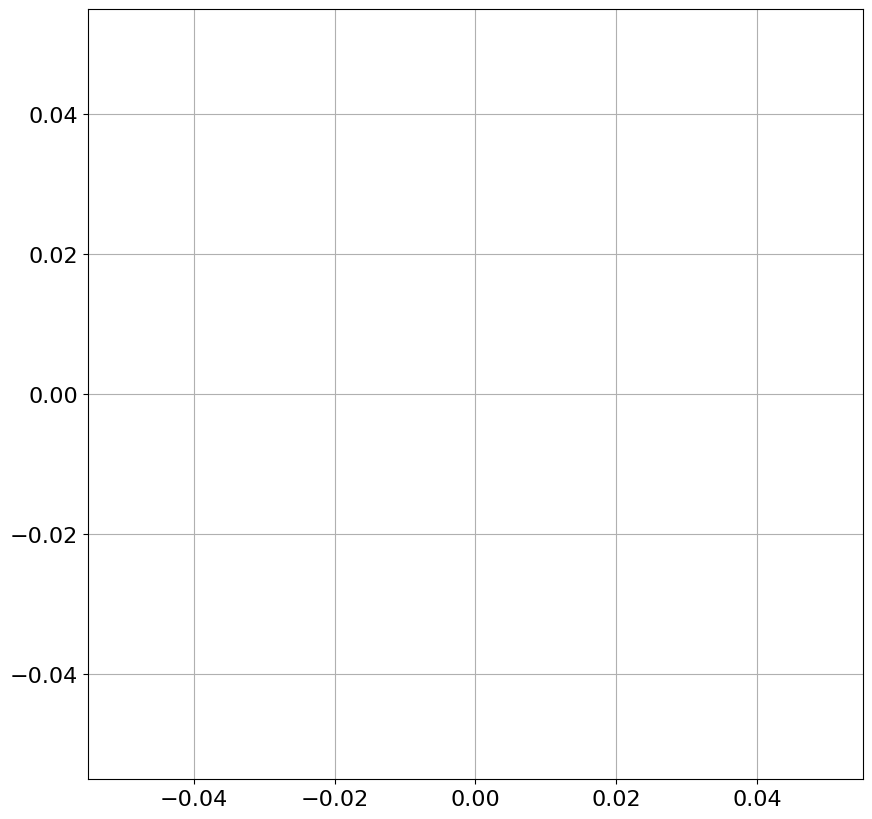

In [14]:
pass_value_barh(users, "Количество пропусков в пользователях")

пропусков не осталось :) или произошла ошибка в первой части функции


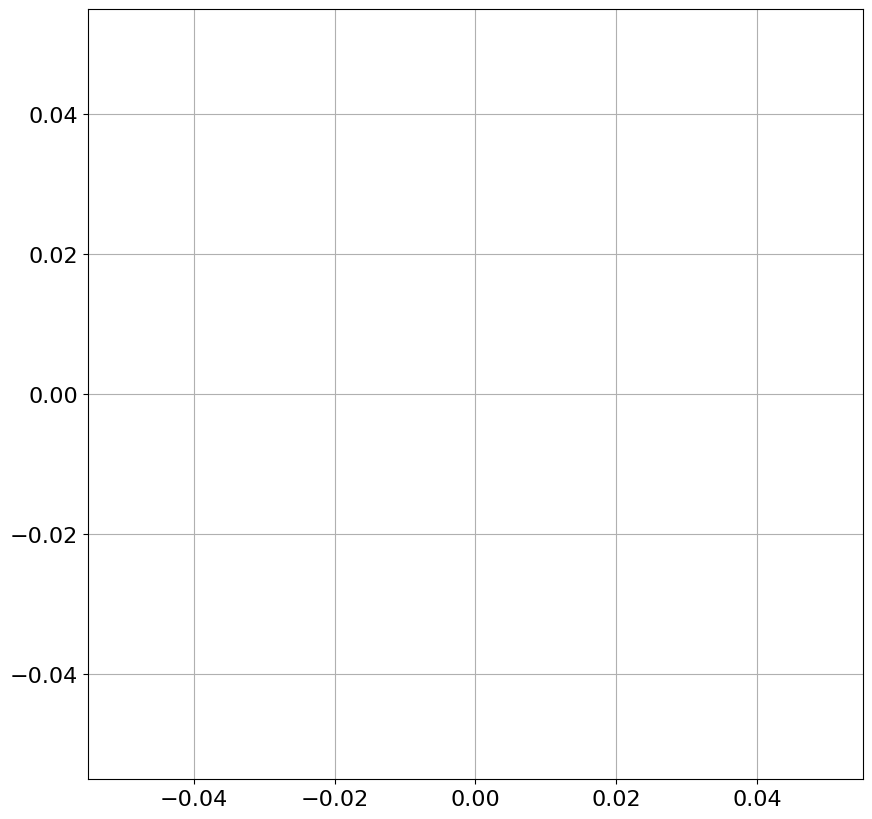

In [15]:
pass_value_barh(rides, "Количество пропусков в поездках")

пропусков не осталось :) или произошла ошибка в первой части функции


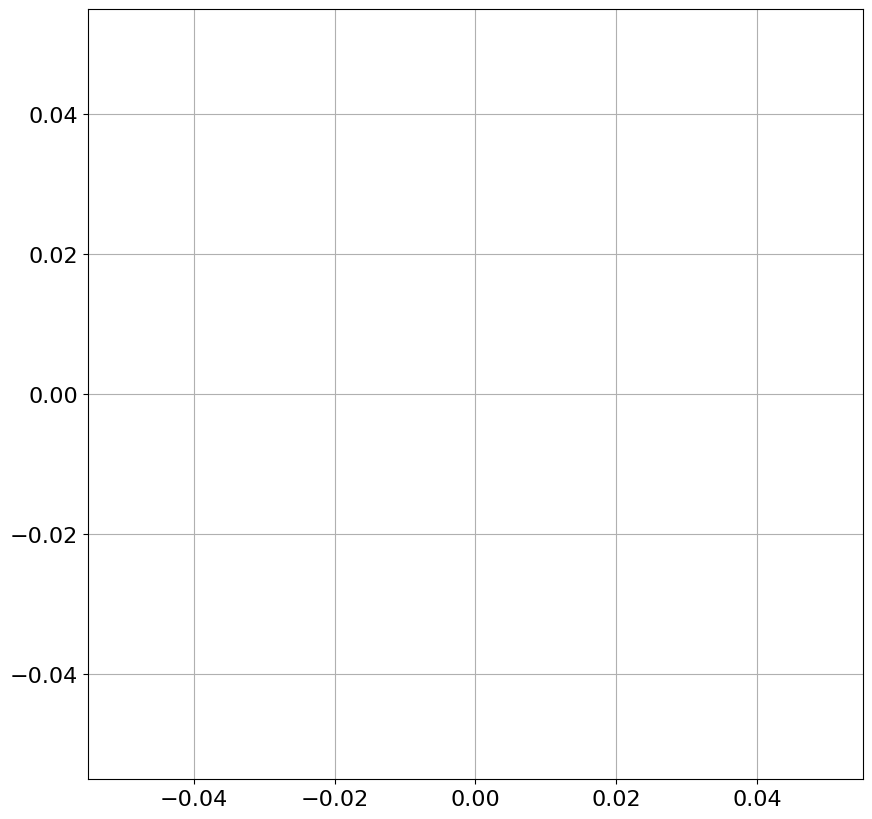

In [16]:
pass_value_barh(subscriptions, "Количество пропусков в подписках")

### Обработаем дубликаты

Проверим наличие явных дубликатов.

In [17]:
users.duplicated().sum()

31

Удалим явные убликаты для пользователей и обновим индекс.

In [18]:
users.drop_duplicates()


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
...,...,...,...,...,...
1529,1530,Ростислав,29,Сочи,free
1530,1531,Никита,25,Пятигорск,free
1531,1532,Алексей,26,Тюмень,free
1532,1533,Степан,22,Краснодар,free


In [19]:
users = users.reset_index(drop=True)

In [20]:
rides.duplicated().sum()

0

In [21]:
subscriptions.duplicated().sum()

0

## EDA

### Ознакомимся с пользователями.

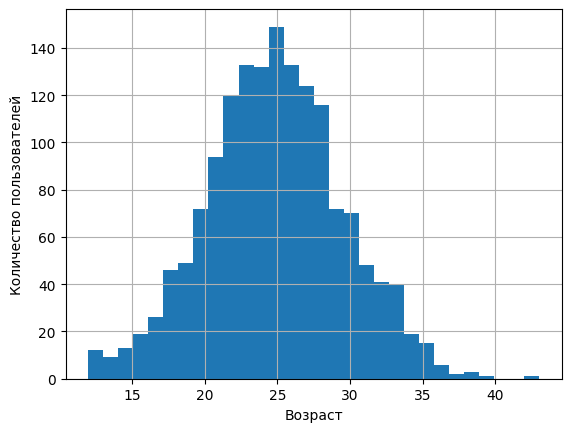

In [22]:
users["age"].hist(bins=30)
plt.xlabel("Возраст")
plt.ylabel("Количество пользователей")
plt.show()

Чаще всего арендой электросамокатов пользуется молодёжь от 20 до 30 лет. 25 лет — самый популярный возраст.

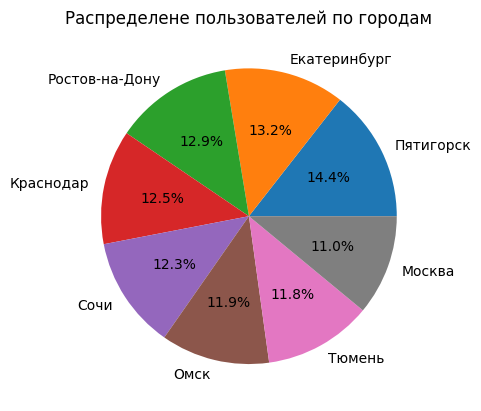

In [23]:
distribution = users["city"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = distribution.index, autopct="%1.1f%%")
ax.set_title("Распределене пользователей по городам")
plt.show()

Пользователи распределены по городам относительно "равномерно".

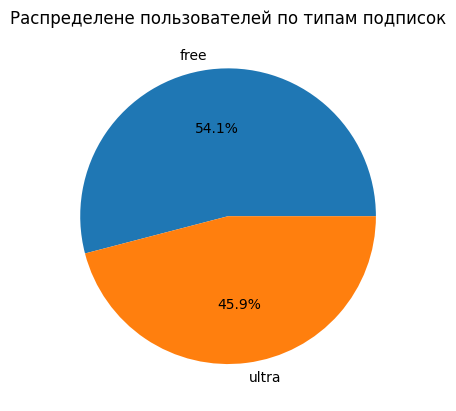

In [24]:
distribution = users["subscription_type"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = distribution.index, autopct="%1.1f%%")
ax.set_title("Распределене пользователей по типам подписок")
plt.show()

Немного больше, около 10% разницы, пользователей, которые пользуются сервисом аренды без подписки.

### Ознакомимся с поездками

Рассмотрим расстояние, которое пользователи проезжают за одну поездку.

In [25]:
def rides_frequencies(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.hist(df["distance"], bins=30)
    ax1.set_title('Частота расстояния поездки')
    ax1.set_xlabel("Расстояние в метрах")
    ax1.set_ylabel("Количество пользователей")

    ax2.hist(df["duration"], bins=30)
    ax2.set_title('Частота длительности поездки')
    ax2.set_xlabel("Продолжительность в минутах")
    ax2.set_ylabel("Количество пользователей")

    plt.tight_layout()
    plt.show()

Рассмотрим продолжительность поездок по времени и расстоянию.

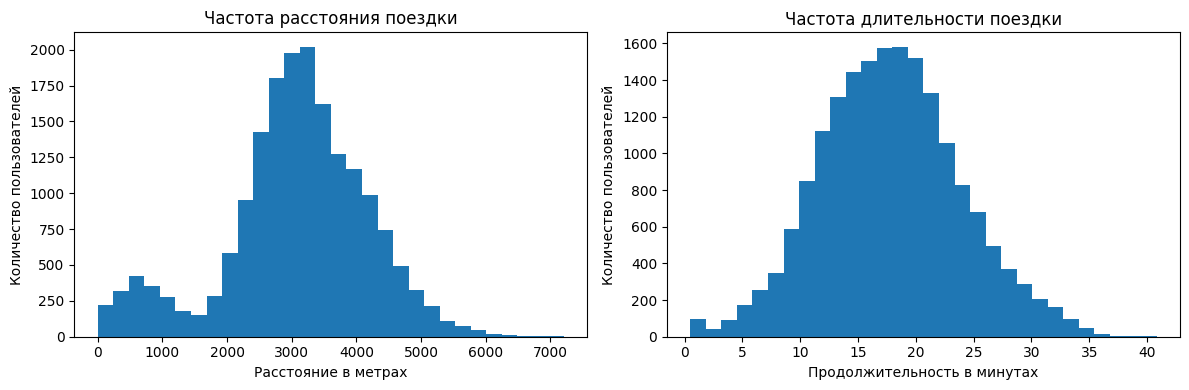

In [26]:
rides_frequencies(rides)

Обратим внимание, что график частот расстояния поездок мультимодальный. Пользователи проезжают либо около 600 метров, либо значительно больше, около 3100 метров.

График частот времени поездок тоже мультимодальный. Пользователи едут либо около 1 минуты, либо значительно больше, около 19 минут. При этом заметно, что дисперсия графика по продолжительности поездки выше, чем по расстоянию.

### Объединим части данных

In [27]:
df = rides.merge(users, on='user_id', how='left').merge(subscriptions, on='subscription_type', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18388 entries, 0 to 18387
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18388 non-null  int64         
 1   distance           18388 non-null  float64       
 2   duration           18388 non-null  float64       
 3   date               18388 non-null  datetime64[ns]
 4   month_number       18388 non-null  int64         
 5   name               18388 non-null  object        
 6   age                18388 non-null  int64         
 7   city               18388 non-null  object        
 8   subscription_type  18388 non-null  object        
 9   minute_price       18388 non-null  int64         
 10  start_ride_price   18388 non-null  int64         
 11  subscription_fee   18388 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


Добавим два датафрейма с пользователями у которых есть и отсутствует подписка для удобства. 

In [28]:
subscribed = df[df["subscription_type"] == "ultra"].reset_index(drop=True)
subscribed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6672 entries, 0 to 6671
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6672 non-null   int64         
 1   distance           6672 non-null   float64       
 2   duration           6672 non-null   float64       
 3   date               6672 non-null   datetime64[ns]
 4   month_number       6672 non-null   int64         
 5   name               6672 non-null   object        
 6   age                6672 non-null   int64         
 7   city               6672 non-null   object        
 8   subscription_type  6672 non-null   object        
 9   minute_price       6672 non-null   int64         
 10  start_ride_price   6672 non-null   int64         
 11  subscription_fee   6672 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 625.6+ KB


In [29]:
unsubscribed = df.loc[df.index.difference(subscribed.index)].reset_index(drop=True)
unsubscribed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11716 entries, 0 to 11715
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11716 non-null  int64         
 1   distance           11716 non-null  float64       
 2   duration           11716 non-null  float64       
 3   date               11716 non-null  datetime64[ns]
 4   month_number       11716 non-null  int64         
 5   name               11716 non-null  object        
 6   age                11716 non-null  int64         
 7   city               11716 non-null  object        
 8   subscription_type  11716 non-null  object        
 9   minute_price       11716 non-null  int64         
 10  start_ride_price   11716 non-null  int64         
 11  subscription_fee   11716 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.1+ MB


### Изучим, какие частоты у расстояния поездок и времени поездок для пользователей с подписками и без

Пользователи с подпиской


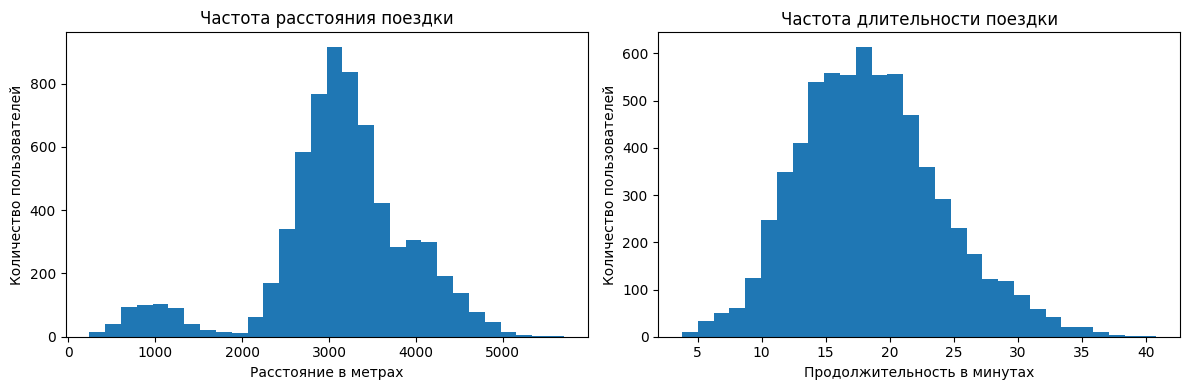

In [30]:
print("Пользователи с подпиской")
rides_frequencies(subscribed)

Пользователи без подписки


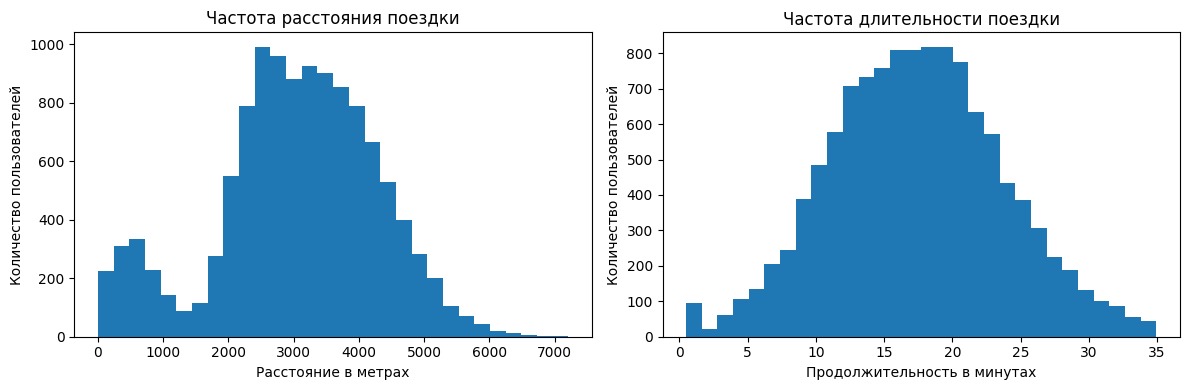

In [31]:
print("Пользователи без подписки")
rides_frequencies(unsubscribed)

Расстояние средней поездки схоже для обеих групп пользователей. Однако заметно, что пользователи без подписки чаще проезжают более короткое расстояние.

Касаемо времени пролдолжительности поездки, пользователи без подписки чаще заканчивают поездку на первой минуте. При этом среднее время поездки для обеих групп пользователей схожее. 

## Подсчёт выручки

In [32]:
user_stats = df.groupby("user_id").agg(
    total_distance = ("distance", "sum"),
    rides_count = ("distance", "count"),
    total_duration = ("duration", "sum")
).reset_index()
user_stats.head()

,user_id,total_distance,rides_count,total_duration
0,1,34070.182066,12,204.604909
1,2,33964.058614,11,197.644279
2,3,36907.597866,12,233.193513
3,4,44837.189916,14,288.563581
4,5,35556.949649,11,174.073932


In [43]:
free = subscriptions[subscriptions["subscription_type"] == "free"].iloc[0]
sub = subscriptions[subscriptions["subscription_type"] == "ultra"].iloc[0]

def calculate_revenue(row):
    if users[users["user_id"] == row["user_id"]].iloc[0]["subscription_type"] == "free":
        return int(free["minute_price"] * math.ceil(row["total_duration"]) + free["start_ride_price"] * row["rides_count"] + free["subscription_fee"])
    else:
        return int(sub["minute_price"] * math.ceil(row["total_duration"]) + sub["start_ride_price"] * row["rides_count"] + sub["subscription_fee"])

user_stats["revenue"] = user_stats.apply(calculate_revenue, axis=1)
user_stats.head()

,user_id,total_distance,rides_count,total_duration,revenue
0,1,34070.182066,12,204.604909,1429
1,2,33964.058614,11,197.644279,1387
2,3,36907.597866,12,233.193513,1603
3,4,44837.189916,14,288.563581,1933
4,5,35556.949649,11,174.073932,1249


Количество информации о фильмах росло год от года. Наиболее полные данные представлены за 2015-2018 годы.

### Изучим как менялась динамика проката по годам

In [ ]:
profits = df.pivot_table(index="start_year", values="box_office", aggfunc="sum").plot(xlabel="Год", \
    ylabel="Сумма кассовых сборов", grid=True, title="Суммарные кассовые сборы по годам");

Сумма кассовых сборов увеличивалась с 2013 года и достигла максимальных значений в 2016+ годах. Наибольшие кассовые сборы со всех фильмов пришлись на 2018 год. Минимальные же сборы были в 2013, 2014 годах. После 2014 года наблюдаем значительный рост. Есть гипотеза, что это может быть связано с началом существенного госфинансирования.

<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4", color = "DimGrey"><b>⚠️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Стоит отметить взрывной рост сборов в 2014 году, интересно с чем это может быть связано?

<div class="alert alert-info">
<font size="4", color = "black">Сформулировал гипотезу для дальнейшей проверки.</font>
    <br /> 
    <font size="3", color = "black">
<br />      

<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4", color = "DimGrey"><b>⚠️ Комментарий ревьюера в2</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Кажется, причина в этом
        
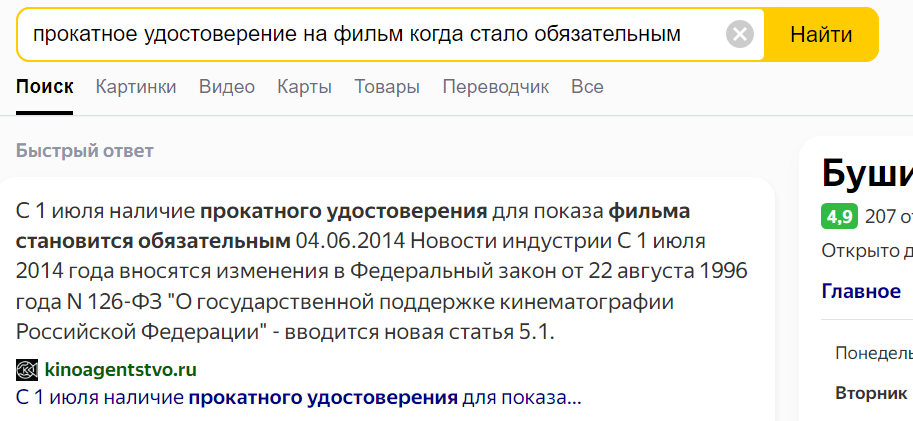

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера в2</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 
И возможно часть ошибок в колонке сборов с продаж связана с форматом данных, кажется, таких ошибок особенно много до середины 2014 г. (пока прокатное удостоверение не стало обязательным)
        
    5296	Бой с тенью-3: последний раунд	111007211	2011-10-18 12:00:00+00:00	Художественный	ООО "Шаман пикчерс"	Россия	А.Сидоров	Неизвестно	«16+» - для детей старше 16 лет	NaN	NaN	NaN	NaN	6.30	боевик,драма,криминал	
        
        сборы - 500.00        
        
Здесь скорее млн. руб., а не рубли
        
Бой с тенью-3: последний раунд, сборы        
        
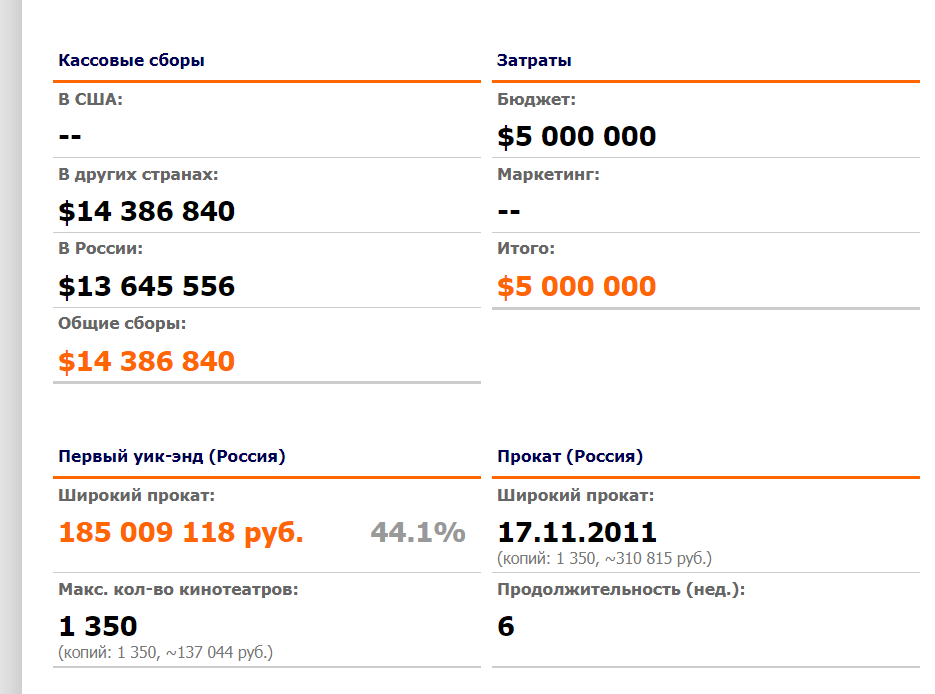        

<div class="alert alert-info">
<font size="4", color = "black">Сейчас болею и проблемы со внимательностью и гипотезами. Обрабатывать невалидный формат сборов вручную будет сложно и ресурсозатратно. Других идей нет. Учту необходимость гуглить подозрительные даты на будещее.</font>
    <br /> 
    <font size="3", color = "black">
<br />      

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера в3</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Выздоравливай 🤝 
        
         Обрабатывать невалидный формат сборов вручную будет сложно и ресурсозатратно.
        
Тут важно другое — на графике видим странный выброс, по этой причине мы можем поискать внешний фактор, который мог повлиять на отрасль и объяснить нашу аномалию

In [ ]:
df.pivot_table(index="start_year", values="box_office", aggfunc={"box_office" : ["mean", "median"]}) \
    .plot(xlabel="Год", ylabel="Кассовые сборы", grid=True, title="Средние значения кассовых сборов по годам");

После 2013 года средние значения кассовых сборов начали расти значительно быстрее медианных. Пик этого разрыва пришёлся на 2017 год. Из этого можно сделать вывод, что с 2013 года в прокате начали с каждым годом всё чаще появляться всё более и более успешные относительно других актуальных фильмов картины. При этом нужно отмасштабировать 2010-2013 годы для более детального анализа.

In [ ]:
cropped_avg_box_office = df.query("start_year <= 2013").pivot_table(index="start_year", values="box_office", aggfunc={"box_office" : ["mean", "median"]})
cropped_avg_box_office.plot(xlabel="Год", ylabel="Кассовые сборы", grid=True, title="Средние значения кассовых сборов по годам").set_xticks(cropped_avg_box_office.index);

С 2010 года до 2013 года средние значения также превосходили медианные. Разрыв с большего увеличивался год от года с исключением в 2011 году. 

<div class="alert alert-dan ger">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Стоит поправить вывод: разница между медианой и средним значительна и в предыдущие годы, твой график скрывает эту разницу
        
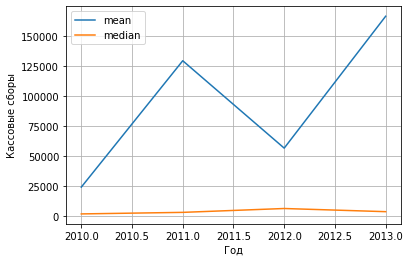        

<div class="alert alert-info">
<font size="4", color = "black">Исправил поверхностный вывод.</font>
    <br /> 
    <font size="3", color = "black">
<br />      

<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4", color = "DimGrey"><b>⚠️ Комментарий ревьюера в2</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Кажется, причина в блокбастерах, которые задирают среднее намного выше медианы

In [ ]:
box_office_mean = df.query("start_year <= 2013")["box_office"].mean()
df.query("start_year <= 2013 and box_office > @box_office_mean").head()

<div class="alert alert-info">
<font size="4", color = "black">Рассмотрели список подобных фильмов и убедились в верности гипотезы.</font>
    <br /> 
    <font size="3", color = "black">
<br />      

### Определим влияние возрастного ограничения на сборы

In [ ]:
age_box_office_mean = df[(df['start_year'] >= 2015) & (df['start_year'] < 2019)] \
    .pivot_table(index="start_year", columns="age_restriction", values="box_office", aggfunc="mean")
age_box_office_median = df[(df['start_year'] >= 2015) & (df['start_year'] < 2019)] \
    .pivot_table(index="start_year", columns="age_restriction", values="box_office", aggfunc="median")

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 10))

# График для средних значений
age_box_office_mean.plot(ax=ax0, xlabel="Год", ylabel="Средние кассовые сборы", grid=True, 
    title="Динамика сборов от возраста аудитории (Средние значения)")
ax0.set_xticks(age_box_office_mean.index)
ax0.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# График для медианных значений
age_box_office_median.plot(ax=ax1, xlabel="Год", ylabel="Медианные кассовые сборы", grid=True, 
    title="Динамика сборов от возраста аудитории (Медианные значения)")
ax1.set_xticks(age_box_office_median.index)
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4", color = "DimGrey"><b>⚠️  Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
        
Можно подправить подписи оси х, в виде целых 2015, 2016 ..., 
        
Для графиков, построенных при помощи библиотеки matplotlib искать тему Ticks and ticklabels
        
https://matplotlib.org/stable/tutorials/text/text_intro.html
        
или
        
https://dev-gang.ru/article/izmenenie-czastoty-tikov-v-matplotlib-k5x1kznn39/?ysclid=lcp5si8pky848462627
        
для библиотеки plotly
        
https://plotly.com/python/tick-formatting/             

<div class="alert alert-dan ger">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Стоит переместить легенду за край графика

<div class="alert alert-info">
<font size="4", color = "black">Сделал.</font>
    <br /> 
    <font size="3", color = "black">
<br />      

<div class="alert alert-dang er">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Стоит полностью оформить все графики на проекте, осталось добавить названия для графиков

<div class="alert alert-info">
<font size="4", color = "black">Улучшил восприятие графиков их расположением.</font>
    <br /> 
    <font size="3", color = "black">
<br />      

После анализа среднего и медианного значения кассовых сборов по годам в зависимости от возрастной категории фильмов очевидно, что наиболее успешны в прокате фильмы с возрастной категорией 6+. Однако, в силу демографических изменений этот тренд меняется в среднем в 2017 году т.к. в целевой аудитории 12+, вероятно, становится больше зрителей.

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера  </b></font>
    <br /> 
    <font size="3", color = "black">
<br />Отлично — посмотрели и на средние значения сборов, и медианные. Осталось посмотреть на суммарные 

## Исследование государственного субсидирования

### Посмотрим на динамику суммарного субсидирования по годам

In [ ]:
subsidized = df.query("refundable_support.notna() or nonrefundable_support.notna()")
subsidized.info()

Рассмотрим суммарные значения финансируемых безвозмездно и с возвратом проектов.

In [ ]:
subsidized = subsidized.copy()
subsidized["grants"] = subsidized["nonrefundable_support"].add(subsidized["refundable_support"], fill_value=0)
avg_grants = pd.pivot_table(subsidized, index="start_year", values="grants", aggfunc={"grants" : ["mean", "median"]}) \
    .plot(xlabel="Год", ylabel="Cубсидии в рублях", grid=True, title="Динамика суммарных субсидий");

Суммарные субсидии с большего растут год от года. При этом после 2015 года больше проектов начали получать большее относительно рынка субсидирование. При этом в 2018 году разрыв сильно сократился, что может означать более аккуратное распределение бюджета субсидирования.

Рассмотрим далее подробнее динамику временных субсидий.

In [ ]:
subsidized.pivot_table(index="start_year", values="refundable_support", aggfunc={"refundable_support" : ["mean", "median"]}) \
    .plot(xlabel="Год", ylabel="Временные субсидии в рублях", grid=True, title="Динамика временных субсидий");

Заметим, что после 2013 года начали появляться проекты, которые получали больше временных субсидий, чем большинство остальных субсидируемых проектов.

Посмотрим, сколько всего субсидируемых с условием возврата денег фильмов было по годам.

In [ ]:
subsidized.pivot_table(index="start_year", values="refundable_support", aggfunc="count") \
.plot(xlabel="Год", ylabel="Количество временных субсидий", grid=True, title="Количество временных субсидий по годам");

Заметим, что количество временных субсидий отдалённо напоминает динамику суммарных кассовых сборов, что подтверждает нашу гипотезу о взрывном росте кассовых сборов в 2015 году.

Проанализируем безвозмездные субсидии таким же образом.

In [ ]:
subsidized.pivot_table(index="start_year", values="nonrefundable_support", aggfunc={"nonrefundable_support" : ["mean", "median"]}) \
    .plot(xlabel="Год", ylabel="Безвозмездные субсидии", grid=True, title="Динамика безвозмездных субсидий");

Заметим, что безвозмездные субсидии резко падали с 2013 до 2014 года. После 2015 года начался рост безвозмездных субсидий каждый год есть проекты, которые получали безвозмездных субсидий чуть больше, чем остальные. Вероятно, такая динамика связана с реорганизацей в пользу оборонного бюджета.

Посмотрим, сколько всего безвозмездно субсидируемых фильмов было по годам.

In [ ]:
subsidized.pivot_table(index="start_year", values="nonrefundable_support", aggfunc="count") \
    .plot(xlabel="Год", ylabel="Безвозмездные субсидии", grid=True, title="Количество безвозмездных субсидий по годам");

Динамика схожа со временными субсидиями, за исключением того, что в 2017 году безвозмездных субсидий начали давать значительно меньше, чем до этого.

### Проанализируем как субсидии влияют на коммерческую успешность проектов

Сначала рассмотрим временные, потом безвозмездные.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))


ax.scatter(x=subsidized['refundable_support'], y=subsidized['box_office'], 
           s=subsidized['ratings'] ** 3 / 10, alpha=0.3)
ax.axline((0, 0), (1, 1), color='k')
ax.set_xlabel("Временные субсидии")
ax.set_ylabel("Кассовые сборы")
ax.set_title("Рейтинг определяет размер точек")

plt.show()

Заметим, что большинство фильмов смогли превзойти размер временных субсидий кассовыми сборами. При этом рейтинг, который определяет размер точек на графике, чаще больший у фильмов, которые получили меньше прибыли либо вовсе убыточны.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(x=subsidized['nonrefundable_support'], y=subsidized['box_office'], 
           s=subsidized['ratings'] ** 3 / 10, alpha=0.3)
ax.axline((0, 0), (1, 1), color='k')
ax.set_xlabel("Безвозмездные субсидии")
ax.set_ylabel("Кассовые сборы")
ax.set_title("Рейтинг определяет размер точек")
plt.show()

При безвозмездных субсидиях меньшее количество картин становится прибыльными. Также заметно, что рейтинг картин не зависит от их кассовой успешности либо объёма безсозмездного субсидирования. Также заметно, что большее количество картин получают субсидии в районе 25_000_000 рублей и не достигают кассовой успешности либо выходят в безубыток.

Рассмотрим схожий график для суммарных субсидий.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(x=subsidized['grants'], y=subsidized['box_office'], 
           s=subsidized['ratings'] ** 3 / 10, alpha=0.3)
ax.axline((0, 0), (1, 1), color='k')
ax.set_xlabel("Суммарные субсидии")
ax.set_ylabel("Кассовые сборы")
ax.set_title("Рейтинг определяет размер точек")
plt.show()

Видмио, большая часть фильмов не окупает субсидии. Рассчитаем точное отношение количества субсидий к кассовым сборам.

In [ ]:
print(f"Отношение суммарных субсидий к суммарным кассовым сборам субсидируемых проектов составляет: {100 * ( 1 - subsidized['grants'].sum() / subsidized['box_office'].sum()):.2f}%")

### Рассмотрим, какими признаками обладают финансово успешные проекты

<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4", color = "DimGrey"><b>⚠️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
Широкие строки кода рекомендуется делить на всем проекте
        
<a href="https://qastack.ru/programming/53162/how-can-i-do-a-line-break-line-continuation-in-python">Перенос длинных строк кода</a>. 
    
</div>

<div class="alert alert-info">
<font size="4", color = "black">Постарался везде улучшить читаемость переносами кода.</font>
    <br /> 
    <font size="3", color = "black">
<br />      

In [ ]:
# check
overal_profit_ratio = 100 * ( 1 - subsidized['grants'].sum() / subsidized['box_office'].sum())
print(f"Сумма кассовых сборов на {overal_profit_ratio:_.1f}% больше суммы субсидий.")

<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4", color = "DimGrey"><b>⚠️ Комментарий ревьюера в2</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> пример ⬆⬆

<div class="alert alert-info">
<font size="4", color = "black">Переписал комментарий к вычисляемому показателю. Непонятно, что стоит исправить в этом месте.</font>
    <br /> 
    <font size="3", color = "black">
<br />      

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера в3</b></font>
    <br /> 
    <font size="3", color = "black">
<br />Показывал пример про сокращение ширины кода
        
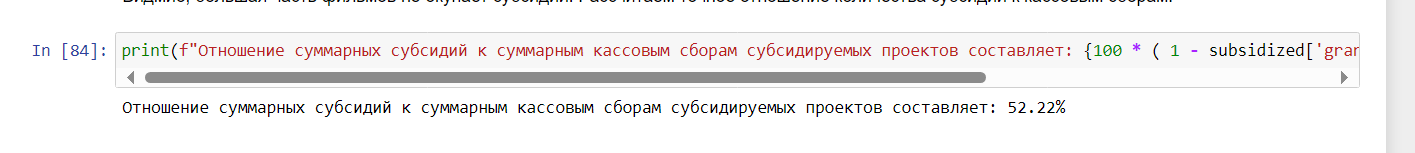        

In [87]:
# subsidized

In [ ]:
subsidized.info()

In [ ]:
succeded_subsidized = subsidized.loc[subsidized["grants"] > subsidized["box_office"]]
succeded_subsidized.info()

In [ ]:
print(f"Доля фильмов, окупивших субсидии составляет: {100 * len(succeded_subsidized.index) / len(subsidized.index):.2f}%")

<div class="alert alert-da nger">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 
        
         Рассмотрим, какими признаками обладают финансово успешные проекты
        
Скажи пожалуйста, получилось ли у тебя корректно отфильтровать успешные фильмы этим кодом?
        
        succeded_subsidized = subsidized[subsidized["refundable_support"] + subsidized["nonrefundable_support"] > subsidized["box_office"]]
        succeded_subsidized.info()

<div class="alert alert-info">
<font size="4", color = "black">Исправил баг с суммированием субсидий.</font>
    <br /> 
    <font size="3", color = "black">
<br />      

Выделим категориальные признаки, которые влияют на успешность картины. 

In [ ]:
successfull_types = succeded_subsidized["type"].value_counts().loc[succeded_subsidized["type"].value_counts() > 0]

fig, ax = plt.subplots()

successfull_types.plot.barh(ax=ax, title="Типы фильмов, успешных в прокате")
ax.set_xlabel("Количество фильмов")
ax.xaxis.get_major_locator().set_params(integer=True)
plt.show()

Предположим, что более успешными в прокате являются художественные фильмы. 

In [ ]:
successfull_studios = succeded_subsidized["film_studio"].value_counts().loc[succeded_subsidized["film_studio"].value_counts() > 2]
fig, ax = plt.subplots()

successfull_studios.plot.barh(ax=ax, title="Студии, успешные в прокате")
ax.set_xlabel("Количество фильмов")
ax.xaxis.get_major_locator().set_params(integer=True)
plt.show()

Получили список студий, которые чаще всего добиваются коммерческого успеха при получении субсидий.

In [ ]:
successfull_directors = succeded_subsidized["main_director"].value_counts().loc[succeded_subsidized["main_director"].value_counts() > 2]
fig, ax = plt.subplots()

successfull_directors.plot.barh(ax=ax, title="Режиссёры, успешные в прокате")
ax.set_xlabel("Количество фильмов")
ax.xaxis.get_major_locator().set_params(integer=True)
plt.show()

Получили список режиссёров, которые чаще остальных делают коммерчиски успешные проекты с учётом субсидирования.

In [ ]:
successfull_genres = succeded_subsidized["main_genre"].value_counts().loc[succeded_subsidized["main_genre"].value_counts() > 2]

fig, ax = plt.subplots()

successfull_genres.plot.barh(ax=ax, title="Жанры фильмов, успешных в прокате")
ax.set_xlabel("Количество фильмов")
ax.xaxis.get_major_locator().set_params(integer=True)
plt.show()

Получили список жанров, подходящих для субсидирования с целью получения коммерчески успешной картины.

Далее проанализируем, какие проекты наоборот с большой долей вероятности не добъются коммерческого успеха. Выделим те из них, успешность которых хуже медианной.

In [ ]:

failed_subsidized = subsidized.loc[subsidized.index.difference(succeded_subsidized.index)]
failed_subsidized.info()

In [ ]:
fail_types = failed_subsidized["type"].value_counts().loc[failed_subsidized["type"].value_counts() > 0]

fig, ax = plt.subplots()

fail_types.plot.barh(ax=ax, title="Типы фильмов, провалившихся в прокате")
ax.set_xlabel("Количество фильмов")
ax.xaxis.get_major_locator().set_params(integer=True)
plt.show()

Т.к. было достаточно успешных художественных т анимационных фильмов, делаем вывод, что толлько документальные фильмы склонны к провалу в прокате.

In [ ]:
fail_studios = failed_subsidized["film_studio"].value_counts().loc[failed_subsidized["film_studio"].value_counts() > 2]
fig, ax = plt.subplots()

fail_studios.plot.barh(ax=ax, title="Студии, провалившиеся в прокате")
ax.set_xlabel("Количество фильмов")
ax.xaxis.get_major_locator().set_params(integer=True)
plt.show()

Получили список студий, которые чаще всего убыточны при получении субсидий.

In [ ]:
fail_directors = failed_subsidized["main_director"].value_counts().loc[failed_subsidized["main_director"].value_counts() > 2]
fig, ax = plt.subplots()

fail_directors.plot.barh(ax=ax, title="Режиссёры, провалившиеся в прокате")
ax.set_xlabel("Количество фильмов")
ax.xaxis.get_major_locator().set_params(integer=True)
plt.show()

Получили список режиссёров, которые чаще остальных снимают убыточные картины.

In [ ]:
fail_genres = failed_subsidized["main_genre"].value_counts().loc[failed_subsidized["main_genre"].value_counts() > 2]

fig, ax = plt.subplots()

fail_genres.plot.barh(ax=ax, title="Жанры фильмов, провальных в прокате")
ax.set_xlabel("Количество фильмов")
ax.xaxis.get_major_locator().set_params(integer=True)
plt.show()

Выяснили список провальных в прокате жанров.

Исходя из не повторяющихся в обоих списках жанров для увеличения кассовой успешности кино, стоит финансировать фильмы в жанрах: детский, детектив, мюзикл, триллер, мелодрама. При этом стоит избегать финансирования картин в жанрах: история, спорт, боевик, семейный и приключения.

<div class="alert alert-dang er">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Стоит полностью  поправить этот подраздел

<div class="alert alert-info">
<font size="4", color = "black">Улучшил качество графиков, переписал выводы после исправления бага в количестве успешных и провальных фильмов.</font>
    <br /> 
    <font size="3", color = "black">
<br />      

<div class="alert alert-d anger">
<font size="4"><b>❌ Комментарий ревьюера в2</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Стоит полностью  поправить  подраздел про жанры

<div class="alert alert-info">
<font size="4", color = "black">Исправил проблему с жанрами и переписал выводы.</font>
    <br /> 
    <font size="3", color = "black">
<br />      

### Проанализируем зависимость рейтинга проектов от субсидий 

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(x=subsidized["grants"], y=subsidized["ratings"], s=subsidized["budget"] / 10 ** 7, alpha=0.3);
ax.set_xlabel("Субсидии")
ax.set_ylabel("Рейтинг")
ax.set_title("Бюджет определяет размер точек")
plt.show()

Делаем вывод, что влияние бюджета на рейтинг незначительно. При этом часто наилучшие показатили рейтинга встречаются у картин, размер субсидий которых менее 70_000_000 рублей. Из этого можно сделать вывод, что финансирование на большие суммы часто бывает неэффективно.

Выделим ТОП-10 успешных режиссеров, которые получили и гос поддержку, и обеспечили наибольшую маржинальность кассовых сборов.

In [ ]:
subsidized["successfulness"] = (subsidized["box_office"] / subsidized["grants"])

top_success = subsidized.query("successfulness.notna()").sort_values("successfulness", ascending=False)

fig, ax = plt.subplots()

top_success.head(10).plot.barh(x="director", y="successfulness", ax=ax, title="ТОП-10 успешных режиссеров, получивших субсидии")
ax.set_xlabel("Отношение кассовых сборов к суммарным субсидиям")
ax.xaxis.get_major_locator().set_params(integer=True)
plt.show()

Также рассмотрим, какие режессёры смогли добиться наибольших значений кассовых сборов при субсидировании и окупить субсидии.

In [ ]:
top_10_directors = subsidized.query("successfulness > 1").sort_values("box_office", ascending=False)

fig, ax = plt.subplots()

top_10_directors.head(10).plot.barh(x="director", y="box_office", ax=ax, title="ТОП-10 режиссеров, получивших наибольшие сборы при субсидировании")
ax.set_xlabel("Кассовых сборы снятых картын")
ax.xaxis.get_major_locator().set_params(integer=True)
plt.show()

Стоит выдавать субсидии режиссёрам из списка учитывая их коммерческий успех. Также стоит обратить внимание на режиссёров, которые многократно превысили субсидирование кассовыми сборами.

<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4", color = "DimGrey"><b>⚠️ Комментарий ревьюера в3</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Стоит поменять колонку  "director" на сокращенный вариант
         
        

Далее рассмотрим режиссёров, которым не удалось окупить субсидии.

In [ ]:
top_fail = subsidized.query("successfulness < 0.1").sort_values("successfulness", ascending=True)

fig, ax = plt.subplots()

top_fail.head(10).plot.barh(x="director", y="successfulness", ax=ax, title="ТОП-10 провалившихся режиссеров, получивших субсидии")
ax.set_xlabel("Отношение кассовых сборов к суммарным субсидиям")
ax.xaxis.get_major_locator().set_params(integer=True)
plt.show()

Получили ТОП-10 антилидеров, которые принесли наибольшие убытки. Таким режиссёрам крайне не рекомендуется выдавать больше субсидии.

In [ ]:
top_fail = subsidized.query("successfulness < 0.5").sort_values("successfulness", ascending=True)

top_fail["director"]

Получили список режиссёров, которые не смогли окупить хотя бы половину субсидий. Им не стоит более выдавать субсидии.

<div class="alert alert-dan ger">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br />
    <font size="3", color = "black">
<br /> Стоит отметить ТОП-10 успешных режиссеров, которые получили и гос поддержку, и обеспечили огромные суммы сборов, чтобы ответить на доп. вопрос — "Кому выдавать деньги в следующем году?"

<div class="alert alert-info">
<font size="4", color = "black">Получил список успешных режиссёров и сделал вывод о необходимости их поддержки.</font>
    <br /> 
    <font size="3", color = "black">
<br />      

<div class="alert alert-dan ger">
<font size="4"><b>❌ Комментарий ревьюера в2</b></font>
    <br />
    <font size="3", color = "black">
<br /> Стоит посмотреть на суммарные сборы и гос.поддержку
        
        Стоит отметить ТОП-10 успешных режиссеров, которые получили и гос поддержку, и обеспечили огромные суммы сборов, чтобы ответить на доп. вопрос — "Кому выдавать деньги в следующем году?"

<div class="alert alert-info">
<font size="4", color = "black">Добавил визуализацию не только относительных, но и абсолютных показателей кассовых сборов для субсидируемых картин. Сделал выводы.</font>
    <br /> 
    <font size="3", color = "black">
<br />      

<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4", color = "DimGrey"><b>⚠️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
        
__Стоит посмотреть на антилидеров, которые принесли суперубытки — ТОП-10__

<div class="alert alert-info">
<font size="4", color = "black">Добавил исследование антилидеров.</font>
    <br /> 
    <font size="3", color = "black">
<br />      

<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4", color = "DimGrey"><b>⚠️ Комментарий ревьюера в2</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Кажется, список антилидеров чуть-чуть другой, потратили огромное кол-во денег и провалились в прокате
        
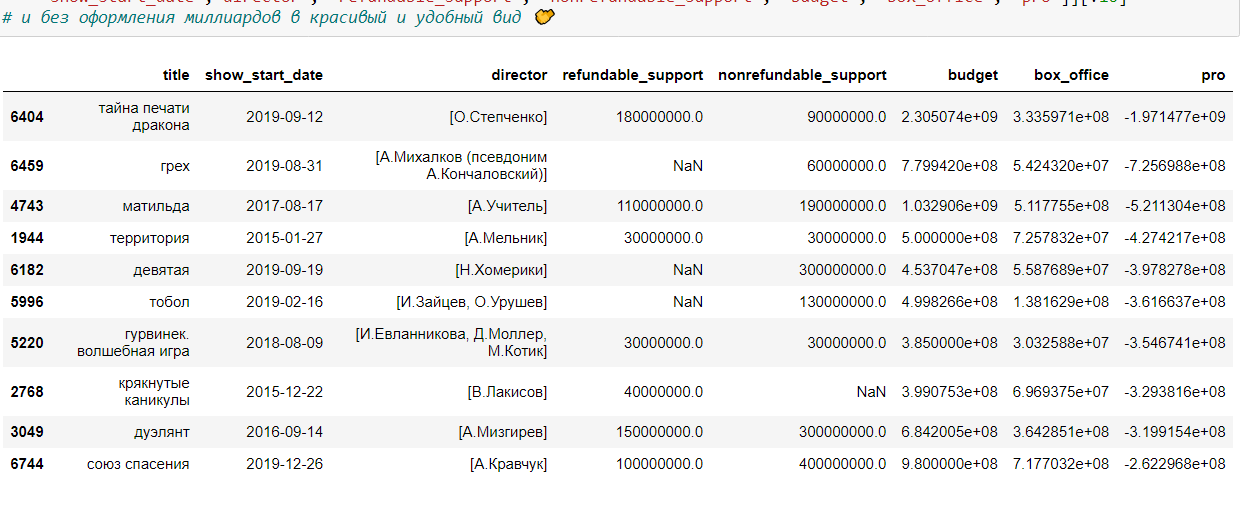        

<div class="alert alert-info">
<font size="4", color = "black">Добавил исследование убыточных режиссёров.</font>
    <br /> 
    <font size="3", color = "black">
<br />      

## Oбщий вывод

В исследовании была произведена подготовка данных:
 - преобразование типов данных
 - объединение источников данных в один набор
 - анализ пропусков в данных
 - устранение дубликатов с аггрегацией их значений
 - создан набор данных без выбросов в количественных данных 
 - созданы для удобства синтетические атрибуты данных
 - проанализировано количество утраченых после подготовки данных

В ходе подготовки данных ознакомились с основными количественными и качественными характеристиками данных.

Анализ показал, что:
 - **Количество** новых **фильмов** часто **менялось** год от года
 - **Доля** фильмов **с указанными кассовыми сборами: 44.21%**
 - **Количество информации** о фильмах **росло** год от года. Наиболее **полные данные** представлены за **2015-2018 годы**
 - **Сумма** кассовых **сборов** **увеличивалась** с 2013 года и достигла максимальных значений в 2016+ годах. **Наибольшие кассовые сборы** со всех фильмов пришлись на **2017 год**. **Минимальные** же **сборы** были в **2013, 2014 годах**.
 - Наиболее **успешны** в прокате **фильмы с возрастной категорией 6+**. Однако появилась **гипотеза**, что **в силу демографических изменений** этот тренд меняется в **2017 году** т.к. в целевой **аудитории 12+**, вероятно, становится **больше зрителей**.
 - **Суммарные субсидии** с большего **растут** год от года.
 - Количество **субсидий** **позитивно влияет** на **количество кассовых сборов**.
 - **60% фильмов** смогли **превзойти** размер **временных субсидий кассовыми сборами**.
 - Удалось выделить **списки студий**, которые чаще остальных **выпускают** коммерчески **успешные картины**.
 - Нашли **ТОП-10 режиссёров**, которые получили **наибольшие кассовые сборы при субсидировании** и **антиТОП-10 режиссёров, провалившихся в прокате**.
 - Стоит **финансировать** фильмы в **жанрах**: **детский, детектив, мюзикл, триллер, мелодрама**. При этом стоит **избегать финансирования** картин в жанрах: **история, спорт, боевик, семейный и приключения**.
 - **Влияние бюджета на рейтинг незначительно**.
 - **Субсидирование** на **большие** чем **70_000_000 рублей** суммы часто бывает **неэффективно**.

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Выполнено исследование с интересным подходом к реализации кода и подготовке данных, молодец

<div class="alert alert-dan ger">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
        
Стоит перепроверить результаты и итоговый вывод после   исправления всех комментариев 
    

<div class="alert alert-info">
<font size="4", color = "black">Переписал вывод в соответствии с доработками в исследовании.</font>
    <br /> 
    <font size="3", color = "black">
<br />      

<div class="alert alert-d anger">
<font size="4"><b>❌ Комментарий ревьюера в2</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
        
Стоит перепроверить результаты и итоговый вывод после   исправления всех комментариев 
    

<div class="alert alert-success">
<font size="5", color= "seagreen"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />   
Ты выполнил практически все пункты проекта, молодец! Проведен значительный объем исследования 
        
        
Критические ❌ комментарии: 
               
 + объяснить какая основная проблема категориальных данных
 + выполнить поиск аномалий в количественных данных  
 + определить успешных режиссеров на гос поддержке        
 + прочие
 + перепроверить промежуточные и итоговый выводы после всех исправлений         
          
        
        
        
Стоит обратить внимание на ⚠️ комментарии...        
        
Если будут вопросы про мои комментарии - задавай, если какой-то формат взаимодействия не устраивает или есть какие-то другие пожелания - пиши :)

<div class="alert alert-success">
    <font size="5", color= "seagreen"><b>Жду твой проект и твои комментарии 🤝</b></font><br />

<div style="border:solid steelblue 3px; padding: 20px">
<font size="4">🍕<b> Комментарий ревьюера</b></font>
<br /> 
<font size="3", color = "black">
<br />    Может пригодиться
    
[Обработка пропусков в данных](https://loginom.ru/blog/missing)
     
        
[Подробное руководство по группировке и агрегированию с помощью pandas](https://dfedorov.spb.ru/pandas/%D0%9F%D0%BE%D0%B4%D1%80%D0%BE%D0%B1%D0%BD%D0%BE%D0%B5%20%D1%80%D1%83%D0%BA%D0%BE%D0%B2%D0%BE%D0%B4%D1%81%D1%82%D0%B2%D0%BE%20%D0%BF%D0%BE%20%D0%B3%D1%80%D1%83%D0%BF%D0%BF%D0%B8%D1%80%D0%BE%D0%B2%D0%BA%D0%B5%20%D0%B8%20%D0%B0%D0%B3%D1%80%D0%B5%D0%B3%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D1%8E%20%D1%81%20%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E%20pandas.html)
 
 
    
[8 способов фильтрации фреймов данных Pandas](https://questu.ru/articles/85248/)    
    
[Визуализация](https://dfedorov.spb.ru/pandas/%D0%AD%D1%84%D1%84%D0%B5%D0%BA%D1%82%D0%B8%D0%B2%D0%BD%D0%BE%D0%B5%20%D0%B8%D1%81%D0%BF%D0%BE%D0%BB%D1%8C%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5%20Matplotlib.html)
 
        
[Постер «Графики, которые убеждают всех»](https://www.notion.so/6c5ae8ceb8b5411e907c93c9b5e6a44e)         

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />Если добавить запятую или знак нижнего подчеркивания, будет удобнее смотреть на большие числа
        
        pd.options.display.float_format = '{:,.2f}'.format
        
        pd.options.display.float_format = '{:_.2f}'.format

### Бонус

<div style="border:solid steelblue 3px; padding: 20px">
<font size="4">🍕<b> Комментарий ревьюера в3</b></font>
<br /> 
<font size="3", color = "black">
<br /> Можно разбить все списки при помощи кода explode (разбиение)
    
<a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.explode.html" rel="noreferrer noopener" target="_blank">explode</a>    
    
Для чего она нужна? Функция explode полезна в тех случаях, когда записи столбца похожи на список: она позволяет создавать новую строку для каждой записи в этих списках. При этом все остальные записи строки будут продублированы, как и индекс. Вызывая эту функцию, вы передаете имя столбца, содержащего спископодобные объекты    
    
    При ее использовании размер датафрейма может увеличиться. Предположим, у вас есть датафрейм с 500 000 строками и столбец, в котором хранятся списки из 100 записей. Вызвав функцию explode для этого столбца, вы в итоге получите 50 000 000 строк. Это может стать проблемой. Поэтому мой совет таков: используйте explode с осторожностью!
    
[Четыре метода, которые повысят качество работы с Pandas](https://nuancesprog.ru/p/15496/?ysclid=lqwok44vr9838974329)    
    
стоит обратить внимание на первый и на четвертый    
    
    

In [105]:
# import pandas as pd
n_rows = 3
result = pd.DataFrame(
    {"a": [list(range(1 + i ** 2)) for i in range(n_rows)], "b": list(range(n_rows))}
)

In [ ]:
result

In [ ]:
result.loc[3]=([4, 2, 1, 4, 3], 2)
result

In [ ]:
result = result.explode("a").astype({'a':int})
result

In [ ]:
result.info()

In [ ]:
result.duplicated().sum()

<div style="border:solid steelblue 3px; padding: 20px">
<font size="4">🍕<b> Комментарий ревьюера в3</b></font>
<br /> 
<font size="3", color = "black">
<br /> 
    
Стоит попросить наставника провести вебинар на тему: «Автоматизация работы по исключению основных ошибок в текстовых данных»       
    
способы работы с регулярными выражениями
        
статья масштабная, но если тема интересует, то пригодится
        
[Регулярные выражения в Python ](https://habr.com/ru/post/349860/?ysclid=l7al1yi73m163595855)
        
[Примеры использования регулярных выражений в поиске](https://kanoki.org/2019/11/12/how-to-use-regex-in-pandas/) 
    
 
          